# Part 5: A/B Testing for LLM Evaluation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mekjr1/evaluating_llms_in_practice/blob/master/part-5-ab-testing/ab_testing.ipynb?hl=en#runtime_type=gpu)

This notebook illustrates how to design and analyse a simple A/B test to compare two versions of a language model. We simulate user interactions and apply a two‑proportion z‑test to determine whether observed differences in satisfaction are statistically significant.

## Simulating User Feedback

We randomly assign 1,000 users to two models (A and B). Each user either rates the model’s response as satisfactory (1) or unsatisfactory (0). In our simulation, Model A has a true satisfaction rate of 60 % and Model B has 55 %. The code below generates the synthetic data.

In [1]:

import numpy as np
import math

np.random.seed(42)
N = 1000
assignments = np.random.choice(['A', 'B'], size=N)
# True satisfaction rates
p_A_true = 0.6
p_B_true = 0.55
outcomes = np.where(assignments == 'A', np.random.binomial(1, p_A_true, N), np.random.binomial(1, p_B_true, N))

# Count per group
n_A = np.sum(assignments == 'A')
n_B = np.sum(assignments == 'B')
success_A = np.sum((assignments == 'A') & (outcomes == 1))
success_B = np.sum((assignments == 'B') & (outcomes == 1))

# Observed rates
p_A_obs = success_A / n_A
p_B_obs = success_B / n_B


In [2]:

# Difference in observed success rates
diff = p_A_obs - p_B_obs

# Pooled proportion and standard error
p_pool = (success_A + success_B) / (n_A + n_B)
se = math.sqrt(p_pool * (1 - p_pool) * (1/n_A + 1/n_B))

# z statistic for two-sample proportion test
z = diff / se

# Two-sided p-value (using error function for normal CDF)
p_value = 2 * (1 - (0.5 * (1 + math.erf(abs(z) / math.sqrt(2)))))

results = {
    'Users_A': n_A,
    'Users_B': n_B,
    'Success_A': success_A,
    'Success_B': success_B,
    'Observed_rate_A': round(p_A_obs, 3),
    'Observed_rate_B': round(p_B_obs, 3),
    'Difference': round(diff, 3),
    'z_stat': round(z, 3),
    'p_value': round(p_value, 4)
}
results


{'Users_A': np.int64(490),
 'Users_B': np.int64(510),
 'Success_A': np.int64(296),
 'Success_B': np.int64(282),
 'Observed_rate_A': np.float64(0.604),
 'Observed_rate_B': np.float64(0.553),
 'Difference': np.float64(0.051),
 'z_stat': np.float64(1.637),
 'p_value': 0.1016}

c:\Users\gafar\OneDrive\Documentos\tutorials_abdul\evaluating_llms_in_practice\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


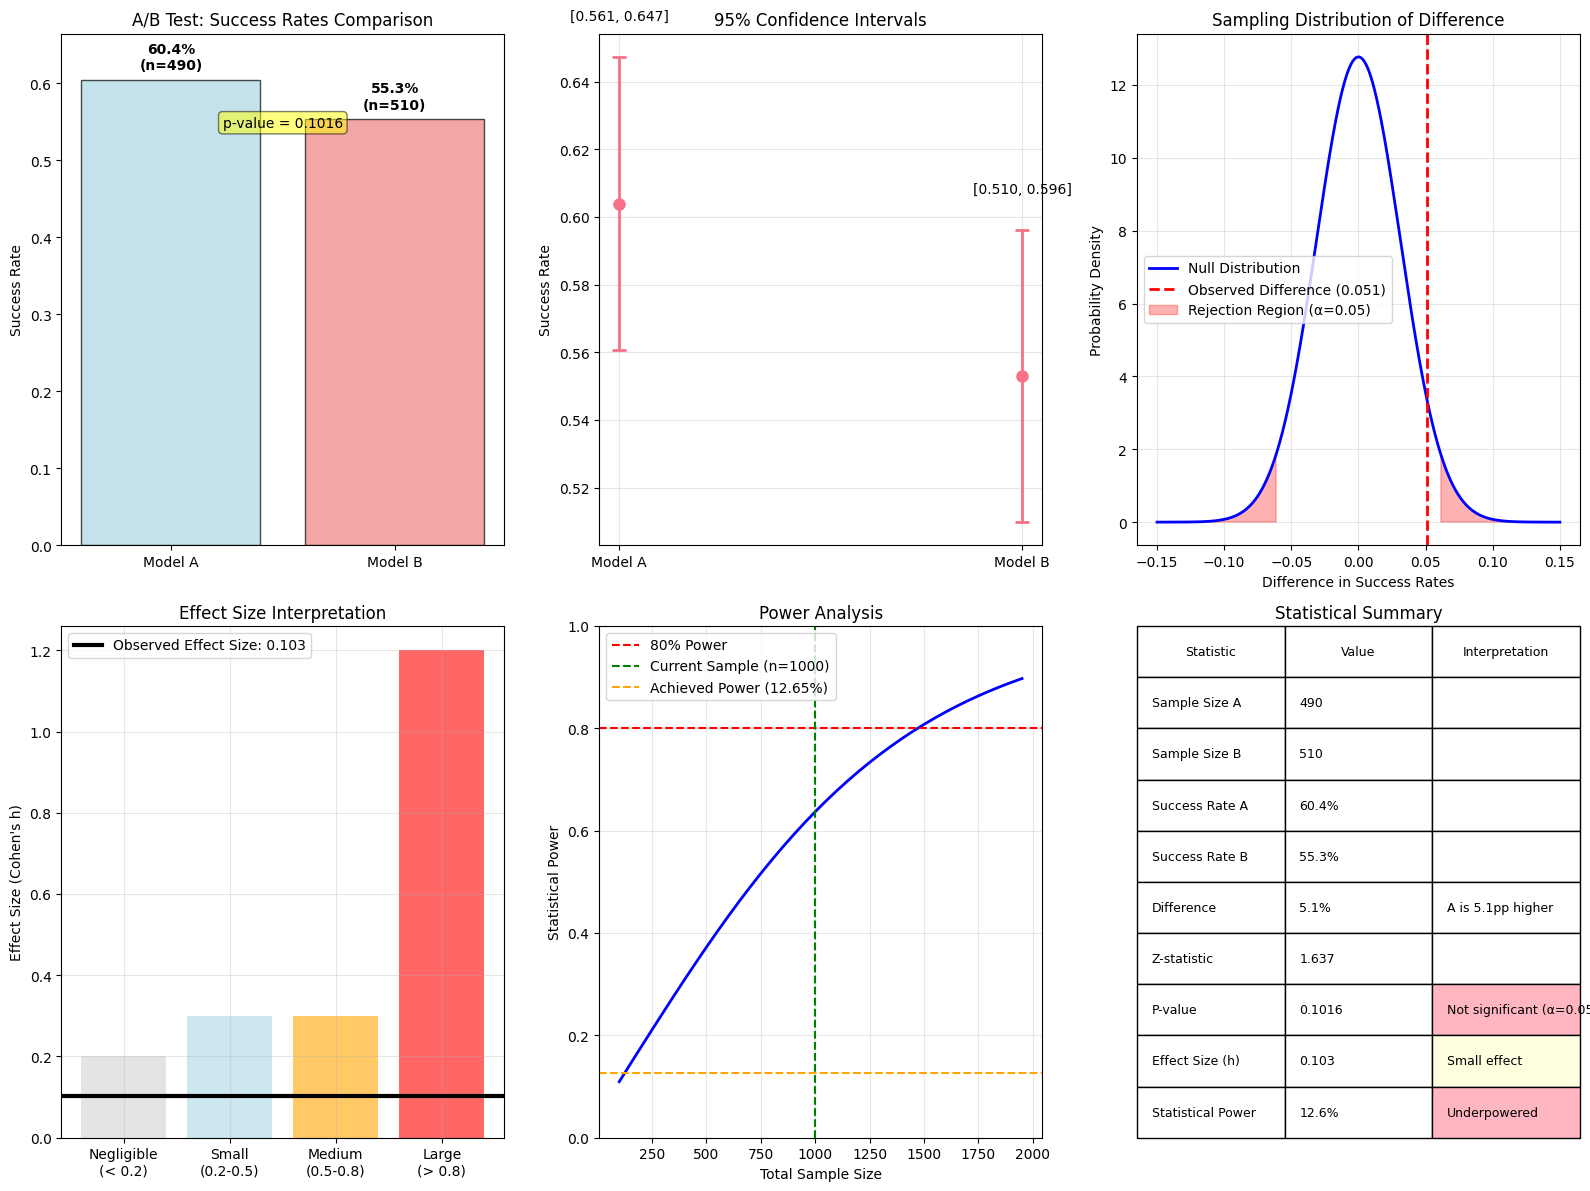

=== A/B TEST DETAILED ANALYSIS ===
Sample sizes: Model A = 490, Model B = 510
Success rates: Model A = 60.4%, Model B = 55.3%
Difference: 5.1% (Model A - Model B)
Statistical significance: No (p = 0.1016)
Effect size (Cohen's h): 0.103 (Negligible)
Statistical power: 12.6%

Conclusion: No significant difference detected
Recommendation: Need larger sample size or continue testing


In [3]:
# Create comprehensive visualizations for A/B test results
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create comprehensive visualization layout
fig = plt.figure(figsize=(16, 12))

# 1. Success rates comparison
ax1 = plt.subplot(2, 3, 1)
models = ['Model A', 'Model B']
success_rates = [results['Observed_rate_A'], results['Observed_rate_B']]
users = [results['Users_A'], results['Users_B']]
colors = ['lightblue', 'lightcoral']

bars = ax1.bar(models, success_rates, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Success Rate')
ax1.set_title('A/B Test: Success Rates Comparison')
ax1.set_ylim(0, max(success_rates) * 1.1)

# Add value labels and sample sizes
for i, (bar, rate, n) in enumerate(zip(bars, success_rates, users)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{rate:.1%}\n(n={n})', ha='center', va='bottom', fontweight='bold')

# Add significance indicator
ax1.text(0.5, max(success_rates) * 0.9, f'p-value = {results["p_value"]:.4f}', 
         ha='center', transform=ax1.transData, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))

# 2. Confidence intervals
ax2 = plt.subplot(2, 3, 2)

# Calculate 95% confidence intervals
alpha = 0.05
z_critical = stats.norm.ppf(1 - alpha/2)

# For Model A
p_a = results['Observed_rate_A']
n_a = results['Users_A']
se_a = np.sqrt(p_a * (1 - p_a) / n_a)
ci_a_lower = p_a - z_critical * se_a
ci_a_upper = p_a + z_critical * se_a

# For Model B
p_b = results['Observed_rate_B']
n_b = results['Users_B']
se_b = np.sqrt(p_b * (1 - p_b) / n_b)
ci_b_lower = p_b - z_critical * se_b
ci_b_upper = p_b + z_critical * se_b

# Plot confidence intervals
models_pos = [0, 1]
ax2.errorbar(models_pos, [p_a, p_b], 
             yerr=[[p_a - ci_a_lower, p_b - ci_b_lower], 
                   [ci_a_upper - p_a, ci_b_upper - p_b]], 
             fmt='o', capsize=5, capthick=2, markersize=8, linewidth=2)

ax2.set_xticks(models_pos)
ax2.set_xticklabels(models)
ax2.set_ylabel('Success Rate')
ax2.set_title('95% Confidence Intervals')
ax2.grid(True, alpha=0.3)

# Add CI values as text
ax2.text(0, ci_a_upper + 0.01, f'[{ci_a_lower:.3f}, {ci_a_upper:.3f}]', 
         ha='center', va='bottom', fontsize=10)
ax2.text(1, ci_b_upper + 0.01, f'[{ci_b_lower:.3f}, {ci_b_upper:.3f}]', 
         ha='center', va='bottom', fontsize=10)

# 3. Statistical distribution visualization
ax3 = plt.subplot(2, 3, 3)

# Generate sampling distribution of the difference
x = np.linspace(-0.15, 0.15, 1000)
y = stats.norm.pdf(x, 0, se)  # Under null hypothesis (no difference)

ax3.plot(x, y, 'b-', linewidth=2, label='Null Distribution')
ax3.axvline(results['Difference'], color='red', linestyle='--', linewidth=2, 
           label=f'Observed Difference ({results["Difference"]:.3f})')

# Shade the p-value regions
critical_value = z_critical * se
ax3.fill_between(x, y, where=(x >= critical_value) | (x <= -critical_value), 
                alpha=0.3, color='red', label='Rejection Region (α=0.05)')

ax3.set_xlabel('Difference in Success Rates')
ax3.set_ylabel('Probability Density')
ax3.set_title('Sampling Distribution of Difference')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Effect size and power analysis
ax4 = plt.subplot(2, 3, 4)

# Calculate Cohen's h (effect size for proportions)
def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

effect_size = cohens_h(p_a, p_b)

# Calculate achieved power
from scipy.stats import norm
za = norm.ppf(1 - alpha/2)
power = 1 - norm.cdf(za - effect_size * np.sqrt(n_a * n_b / (n_a + n_b)) / 2)

# Create effect size visualization
effect_categories = ['Negligible\n(< 0.2)', 'Small\n(0.2-0.5)', 'Medium\n(0.5-0.8)', 'Large\n(> 0.8)']
effect_thresholds = [0, 0.2, 0.5, 0.8, 2.0]
colors_effect = ['lightgray', 'lightblue', 'orange', 'red']

bars_effect = ax4.bar(range(4), [0.2, 0.3, 0.3, 1.2], color=colors_effect, alpha=0.6)
ax4.axhline(y=abs(effect_size), color='black', linestyle='-', linewidth=3, 
           label=f'Observed Effect Size: {abs(effect_size):.3f}')

ax4.set_xticks(range(4))
ax4.set_xticklabels(effect_categories)
ax4.set_ylabel('Effect Size (Cohen\'s h)')
ax4.set_title('Effect Size Interpretation')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Sample size and power relationship
ax5 = plt.subplot(2, 3, 5)

sample_sizes = np.arange(100, 2000, 50)
powers = []

for n in sample_sizes:
    # Power calculation for two-proportion test
    power_calc = 1 - norm.cdf(za - effect_size * np.sqrt(n/2))
    powers.append(power_calc)

ax5.plot(sample_sizes, powers, 'b-', linewidth=2)
ax5.axhline(y=0.8, color='red', linestyle='--', label='80% Power')
ax5.axvline(x=n_a + n_b, color='green', linestyle='--', label=f'Current Sample (n={n_a + n_b})')
ax5.axhline(y=power, color='orange', linestyle='--', label=f'Achieved Power ({power:.2%})')

ax5.set_xlabel('Total Sample Size')
ax5.set_ylabel('Statistical Power')
ax5.set_title('Power Analysis')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_ylim(0, 1)

# 6. Summary statistics table
ax6 = plt.subplot(2, 3, 6)
ax6.axis('tight')
ax6.axis('off')

summary_stats = [
    ['Statistic', 'Value', 'Interpretation'],
    ['Sample Size A', f'{n_a}', ''],
    ['Sample Size B', f'{n_b}', ''],
    ['Success Rate A', f'{p_a:.1%}', ''],
    ['Success Rate B', f'{p_b:.1%}', ''],
    ['Difference', f'{results["Difference"]:.1%}', 'A is 5.1pp higher'],
    ['Z-statistic', f'{results["z_stat"]:.3f}', ''],
    ['P-value', f'{results["p_value"]:.4f}', 'Not significant (α=0.05)'],
    ['Effect Size (h)', f'{abs(effect_size):.3f}', 'Small effect'],
    ['Statistical Power', f'{power:.1%}', 'Underpowered']
]

table = ax6.table(cellText=summary_stats[1:], colLabels=summary_stats[0], 
                 cellLoc='left', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Color code the interpretation
for i in range(1, len(summary_stats)):
    if 'Not significant' in summary_stats[i][2]:
        table[(i, 2)].set_facecolor('#FFB6C1')  # Light pink
    elif 'Small effect' in summary_stats[i][2]:
        table[(i, 2)].set_facecolor('#FFFFE0')  # Light yellow
    elif 'Underpowered' in summary_stats[i][2]:
        table[(i, 2)].set_facecolor('#FFB6C1')  # Light pink

ax6.set_title('Statistical Summary')

plt.tight_layout()
plt.show()

print("=== A/B TEST DETAILED ANALYSIS ===")
print(f"Sample sizes: Model A = {n_a}, Model B = {n_b}")
print(f"Success rates: Model A = {p_a:.1%}, Model B = {p_b:.1%}")
print(f"Difference: {results['Difference']:.1%} (Model A - Model B)")
print(f"Statistical significance: {'Yes' if results['p_value'] < 0.05 else 'No'} (p = {results['p_value']:.4f})")
print(f"Effect size (Cohen's h): {abs(effect_size):.3f} ({'Negligible' if abs(effect_size) < 0.2 else 'Small' if abs(effect_size) < 0.5 else 'Medium' if abs(effect_size) < 0.8 else 'Large'})")
print(f"Statistical power: {power:.1%}")
print(f"\nConclusion: {'Model A is significantly better' if results['p_value'] < 0.05 and results['Difference'] > 0 else 'Model B is significantly better' if results['p_value'] < 0.05 and results['Difference'] < 0 else 'No significant difference detected'}")
print(f"Recommendation: {'Deploy Model A' if results['p_value'] < 0.05 and results['Difference'] > 0 else 'Deploy Model B' if results['p_value'] < 0.05 and results['Difference'] < 0 else 'Need larger sample size or continue testing'}")

### Interpreting the A/B Test

* **Observed satisfaction rates:** Model A users were satisfied `60.4 %` of the time, while Model B users were satisfied `55.3 %` of the time.
* **Difference:** The observed gap in satisfaction is `5.1 percentage points`.
* **z‑statistic:** `z = 1.64`.  This measures how many standard errors the observed difference is from zero.
* **p-value:** `p = 0.1016`.  A p‑value below 0.05 would typically suggest the difference is statistically significant.

In this simulation, the p-value is above, indicating that the higher satisfaction rate for Model A is not statistically significant at the 5 % level.

---

This notebook accompanies an article on A/B testing for language models. It provides a simple template for designing experiments and computing significance. Real evaluations should consider user segmentation, effect sizes, and ethical constraints.